<a href="https://colab.research.google.com/github/bmontoyag/UTEC_MISTI_2026/blob/main/2025mistiperu_cnns_inherentfeatureengineering_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**

# Explore the Inherent Feature Engineering of Convolutional Neural Networks with Pytorch and MNIST

In [2]:
# @title
# ==============================================
# 0. Module imports
# ==============================================

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

device = "cpu"

Some visualization code. No need to understand this cell, but don't forget to run it!

In [3]:
# @title
from graphviz import Digraph

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
def visualize(model):
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    # custom script to get all the shapes of a network's layers
    sizes = list()
    state_dict = net.state_dict()
    for idx, key in enumerate(state_dict.keys()):
      if key.endswith('weight'):
        output_size, input_size = state_dict[key].shape
        if idx == 0:
          sizes.append(input_size)
        sizes.append(output_size)

    input_layer = sizes[0]
    for layer in layers:
        if layer == layers[0]:
            hidden_layers.append(layer.out_features)

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers.append(layer.out_features)

        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename='visualization_tmp')
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
          c.attr(color="white")
          for i in range(0, sizes[0]):
              n += 1
              c.node(str(n))
              c.attr(labeljust="1")
              c.attr(label="Input Layer", labelloc="bottom")
              c.attr(rank="same")
              c.node_attr.update(
                  width="0.65",
                  style="filled",
                  shape="circle",
                  color=HAPPY_COLORS_PALETTE[3],
                  fontcolor=HAPPY_COLORS_PALETTE[3],
              )
    for layer_idx in range(0, len(sizes) - 2):
        with g.subgraph(name="cluster_" + str(layer_idx + 1)) as c:
            c.attr(color="white")
            c.attr(rank="same")
            label = f'Hidden Layer {layer_idx + 1}'
            c.attr(labeljust="right", labelloc="b", label=label)
            for j in range(0, hidden_layers[layer_idx]):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[0],
                    fontcolor=HAPPY_COLORS_PALETTE[0],
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            last_layer_nodes = hidden_layers[layer_idx]
            nodes_up += hidden_layers[layer_idx]

    with g.subgraph(name="cluster_output") as c:
        c.attr(color="white")
        c.attr(rank="same")
        c.attr(labeljust="1")
        for i in range(1, output_layer + 1):
            n += 1
            c.node(
                str(n),
                width="0.65",
                shape="circle",
                style="filled",
                color=HAPPY_COLORS_PALETTE[4],
                fontcolor=HAPPY_COLORS_PALETTE[4],

            )
            for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                g.edge(str(h), str(n))
        c.attr(label="Output Layer", labelloc="bottom")
        c.node_attr.update(
            color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
        )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    g.view()
    return g

## Explore MNIST

### Define DataLoaders

In [4]:
# Define the Batch Sizes
batch_size_train = 64
batch_size_test = 1000

# Training DataLoader
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Testing DataLoader
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.82MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]


## Training a Simple Convolutional Network

The `train()` function is responsible for updating the network's parameters during the **training phase** using data from the training set. It sets the network to **training mode**, enabling layers like dropout that improve generalization. For **fully connected networks**, the input data is flattened into a 1D vector before being passed to the network, but this step is **skipped for convolutional neural networks (CNNs)**, which handle multi-dimensional inputs directly. During each batch, the function performs a **forward pass** to make predictions, calculates the **loss** using the Negative Log Likelihood function, and performs **backpropagation** to update the network’s weights. The function tracks and logs the **training progress** to monitor performance over time.

In [5]:
# Note: network.train() puts the network into "nondeterministic mode".
# This doesn't matter for the fully connected network, but it will matter for convolutional networks.
# CNNs rely on preserving spatial structure, so the nondeterministic mode can impact results.
def train(network, optimizer, epoch, trainloader, flatten_data=True):

    network.train()  # Set the network to training mode
    loss_logs = list()  # Track the loss over time

    for batch_idx, (data, target) in enumerate(trainloader):
        # For fully connected networks, we flatten the image data to feed it into the network.
        # CNNs, however, expect multi-dimensional image inputs, so we skip flattening.
        if flatten_data:
            data = flatten(data)  # Flatten the image (only for fully connected networks)

        # Move data to GPU if available
        data, target = data.to(device), target.to(device)

        # Zero the gradients from the previous batch
        optimizer.zero_grad()

        # Perform the forward pass through the network
        output = network(data)

        # Compute the loss using the Negative Log Likelihood loss function
        # This loss function is often used for classification tasks with multiple classes.
        loss = F.nll_loss(output, target)

        # Backpropagation: Calculate the gradients of the loss with respect to the network's parameters
        loss.backward()

        # Perform the optimization step: Update the network's parameters
        optimizer.step()

        # Print training progress at regular intervals
        if batch_idx % log_interval == 0:
            examples_shown = batch_idx * len(data)
            total_examples = len(trainloader.dataset)
            fraction_shown = round(examples_shown / total_examples * 100.0, 2)
            rounded_loss = round(loss.item(), 4)
            print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

            examples_so_far = batch_idx * len(data) + epoch * len(trainloader.dataset)
            loss_logs.append((examples_so_far, loss.item()))

    return loss_logs

This `test()` function evaluates the performance of a trained neural network on unseen data from the test set. It puts the network into **evaluation mode** to ensure consistent behavior by disabling layers like dropout, which are only active during training. The function then loops through the test data, performs a **forward pass** to generate predictions, and calculates both the **average loss** and **accuracy**. For fully connected networks, the input data must be **flattened into a 1D vector** before being passed to the network, but this step is unnecessary for **convolutional neural networks (CNNs)**, which process multi-dimensional image data directly. The function finally prints the results, helping us assess how well the model generalizes to new data.

In [6]:
def test(network, flatten_data=True):
    # Set the network to evaluation mode.
    # This disables certain behaviors like dropout that are only used during training.
    network.eval()

    # Initialize test loss and correct predictions counters
    test_loss = 0
    correct = 0

    # Disable gradient calculation for efficiency since we are only testing the model.
    with torch.no_grad():
        for data, target in test_loader:
            # For fully connected networks, flatten the image data into a 1D vector.
            # CNNs expect multi-dimensional image inputs, so flattening is unnecessary for them.
            if flatten_data:
                data = flatten(data)

            # Move data and target to the GPU if available
            data, target = data.to(device), target.to(device)

            # Perform a forward pass through the network
            output = network(data)

            # Calculate the cumulative test loss using Negative Log Likelihood loss
            test_loss += F.nll_loss(output, target, size_average=False).item()

            # Get the predicted class for each input sample
            pred = output.data.max(1, keepdim=True)[1]

            # Count the number of correct predictions
            correct += pred.eq(target.data.view_as(pred)).sum()

    # Calculate the average test loss by dividing by the number of samples
    test_loss /= len(test_loader.dataset)

    # Calculate the test accuracy as a percentage
    accuracy = round(100. * correct.item() / len(test_loader.dataset), 2)

    # Print the test loss and accuracy
    print(f'\nTest set: Avg loss {round(test_loss, 4)}, Accuracy {accuracy}%\n')

    # Return the test loss and accuracy for logging purposes
    return test_loss, accuracy

### Define a Simple Convolutional Neural Network

This is a **simple convolutional neural network (CNN)** model called `ConvNet`, designed to classify images into different categories. CNNs are widely used in image processing because they can automatically learn spatial features like edges, textures, and shapes from images. This example includes **two convolutional layers** followed by **fully connected layers** to map the learned features to class probabilities. Each layer in the network serves a specific purpose, such as feature extraction or classification, and the structure is designed to handle image data efficiently.

The `forward()` method defines how the input image flows through the network — from convolutional layers for feature extraction to fully connected layers for decision-making. Below are detailed comments explaining each step in the network.

In [7]:
# Define the convolutional neural network (CNN) architecture
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        # First convolutional layer:
        # - 1 input channel (grayscale image)
        # - 10 output channels (feature maps)
        # - 5x5 kernel size (learns 5x5 filters to detect patterns)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Second convolutional layer:
        # - Takes 10 input feature maps from conv1
        # - Produces 20 output feature maps
        # - 5x5 kernel size
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # Dropout layer to reduce overfitting by randomly dropping units during training
        self.conv2_drop = nn.Dropout2d()

        # First fully connected layer:
        # - 320 input features (flattened feature maps after convolutions)
        # - 50 output features (reduces dimensionality for classification)
        self.fc1 = nn.Linear(320, 50)

        # Second fully connected layer:
        # - 50 input features from the previous layer
        # - 10 output features corresponding to the number of classes
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # First convolutional layer followed by:
        # - ReLU activation (introduces non-linearity)
        # - Max pooling (reduces dimensionality by taking the max value from 2x2 regions)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Second convolutional layer followed by dropout:
        # - Helps reduce overfitting by randomly dropping out units
        x = self.conv2_drop(self.conv2(x))

        # Apply max pooling to reduce the feature map size
        # - Uses a 2x2 pooling region
        x = F.max_pool2d(x, 2)

        # Apply ReLU activation to introduce non-linearity
        x = F.relu(x)

        # Flatten the output to a 1D vector before passing it to fully connected layers
        # - The input size is reshaped to (-1, 320), where -1 infers the batch size
        x = x.view(-1, 320)

        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply dropout to the fully connected layer's output to reduce overfitting
        # - Dropout is only applied during training
        x = F.dropout(x, training=self.training)

        # Apply the second fully connected layer (output layer)
        # - Produces 10 output values corresponding to class scores
        x = self.fc2(x)

        # Return the log of softmax probabilities for classification
        # - Converts the output scores into a categorical probability distribution
        return F.log_softmax(x)

### ANALYZE: Train a Convolutional Neural Network with MNIST

Tasks:
1. Set the hyperparameters (`learning_rate`, `momentum`, `n_epochs`), and then run the following code. As the code is running, move through each line step by step, and try to understand the process of training a convolutional neural network.
  - In general, this code trains a **convolutional neural network (CNN)** using the Stochastic Gradient Descent (SGD) optimization algorithm. The network is trained over multiple epochs, with each epoch consisting of a **training phase** and a **testing phase**. The **hyperparameters** such as learning rate, momentum, and number of epochs control how the training process progresses. After each epoch, the model’s performance on the test set is logged, tracking both **test accuracy** and **loss** over time.
2. Assess the performance of the trained convolutional neural network using the provided function `plot_results(~)`. Would you expect thi performance s to be better than that of a standard feedforward neural network?



```
# This is formatted as code
```

##### TASK 1: Set your Hyperparameters

- Set the hyperparameters (`learning_rate`, `momentum`, `n_epochs`), and then run the following code. As the code is running, move through each line step by step, and try to understand the process of training a convolutional neural network.
  - In general, this code trains a **convolutional neural network (CNN)** using the Stochastic Gradient Descent (SGD) optimization algorithm. The network is trained over multiple epochs, with each epoch consisting of a **training phase** and a **testing phase**. The **hyperparameters** such as learning rate, momentum, and number of epochs control how the training process progresses. After each epoch, the model’s performance on the test set is logged, tracking both **test accuracy** and **loss** over time.

In [8]:
# TASK 1 EXERCISE

# Define hyperparameters
# Hyperparameters control the behavior of the training process.

learning_rate = 0.01  # Controls how large the weight updates are during training.
# A smaller learning rate leads to slower but more stable convergence.
# A larger learning rate can speed up convergence but may cause instability.

momentum = 0.5
# Momentum helps accelerate convergence by adding a fraction of the previous update to the current update.
# This helps the model avoid getting stuck in local minima and smooths the optimization process.

n_epochs = 10
# Number of complete passes through the training dataset during training.
# Increasing the number of epochs can improve performance, but may lead to overfitting if too high.

log_interval = 10
# How often (in batches) we print the training progress.
# For example, a log_interval of 10 means the network will print updates every 10 batches.

# Initialize the convolutional network
conv_network = ConvNet()

# Move the network to the GPU if available
conv_network.to(device)

# Define the optimizer
# We're using SGD (Stochastic Gradient Descent) with the specified learning rate and momentum.
conv_optimizer = optim.SGD(conv_network.parameters(), lr=learning_rate, momentum=momentum)

# Initialize lists to track test accuracy, test losses, and training losses
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0  # Tracks the total number of examples processed during training

# Training loop over the specified number of epochs
for epoch in range(n_epochs):

    # Run the test phase before training each epoch to log initial performance
    test_loss, test_accuracy = test(conv_network, flatten_data=False)

    # Train the network on the training dataset for the current epoch
    train_loss_logs = train(conv_network, conv_optimizer, epoch, train_loader, flatten_data=False)

    # Log test performance
    test_accuracies.append((epoch, test_accuracy))  # Log accuracy for this epoch
    test_losses.append((total_examples_seen, test_loss))  # Log test loss

    # Log training losses
    train_losses.extend(train_loss_logs)

    # Update the total number of examples seen
    total_examples_seen = train_loss_logs[-1][0]

# Final test phase after completing all epochs
test_loss, test_accuracy = test(conv_network, flatten_data=False)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))

# At the end of the training process, we have:
# - test_accuracies: A list tracking the model's accuracy on the test set after each epoch.
# - test_losses: A list tracking the test loss after each epoch.
# - train_losses: A detailed log of the training loss over time.


Test set: Avg loss 2.312, Accuracy 11.6%

Train Epoch 0 Progress: 0.0%	Loss: 2.333
Train Epoch 0 Progress: 1.07%	Loss: 2.3106
Train Epoch 0 Progress: 2.13%	Loss: 2.3107
Train Epoch 0 Progress: 3.2%	Loss: 2.2411
Train Epoch 0 Progress: 4.27%	Loss: 2.2497
Train Epoch 0 Progress: 5.33%	Loss: 2.2158
Train Epoch 0 Progress: 6.4%	Loss: 2.2248
Train Epoch 0 Progress: 7.47%	Loss: 2.1926
Train Epoch 0 Progress: 8.53%	Loss: 2.1502
Train Epoch 0 Progress: 9.6%	Loss: 2.0912
Train Epoch 0 Progress: 10.67%	Loss: 2.0968
Train Epoch 0 Progress: 11.73%	Loss: 1.8975
Train Epoch 0 Progress: 12.8%	Loss: 1.8018
Train Epoch 0 Progress: 13.87%	Loss: 1.8348
Train Epoch 0 Progress: 14.93%	Loss: 1.645
Train Epoch 0 Progress: 16.0%	Loss: 1.6083
Train Epoch 0 Progress: 17.07%	Loss: 1.6695
Train Epoch 0 Progress: 18.13%	Loss: 1.4084
Train Epoch 0 Progress: 19.2%	Loss: 1.0938
Train Epoch 0 Progress: 20.27%	Loss: 1.2307
Train Epoch 0 Progress: 21.33%	Loss: 1.2224
Train Epoch 0 Progress: 22.4%	Loss: 1.2801
Train Epo

#### TASK 2: Assess Performance of Trained Convolutional Neural Network with MNIST

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(test_accuracies, test_losses, train_losses):
    """
    Plot training losses, test losses, and test accuracy over time.

    Parameters:
    - test_accuracies: List of tuples [(epoch, accuracy)], representing test accuracy over epochs.
    - test_losses: List of tuples [(epoch, loss)], representing test loss over examples seen.
    - train_losses: List of tuples [(example, loss)], representing training loss over examples seen.
    """
    # --- Plot Training and Test Losses ---
    plt.figure(figsize=(12, 6))

    # Extract values for training losses
    train_x, train_y = zip(*train_losses)

    # Extract values for test losses
    test_x, test_y = zip(*test_losses)

    # Plot training losses
    plt.plot(train_x, train_y, label='Training Loss', color='b', linestyle='-', marker='.')

    # Plot test losses
    plt.plot(test_x, test_y, label='Test Loss', color='r', linestyle='--', marker='o')

    # Formatting
    plt.xlabel('Examples Seen')
    plt.ylabel('Log Loss')
    plt.title('Training and Test Losses Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot Test Accuracy ---
    plt.figure(figsize=(12, 6))

    # Extract values for test accuracy
    acc_x, acc_y = zip(*test_accuracies)

    # Plot test accuracy
    plt.plot(acc_x, acc_y, label='Test Accuracy', color='g', marker='o')

    # Formatting
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    sns.despine()
    plt.show()

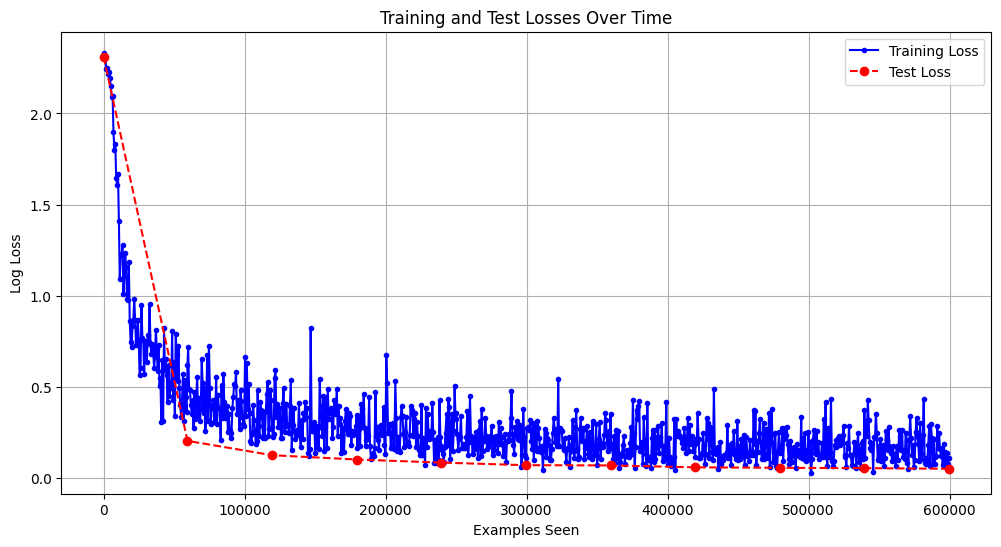

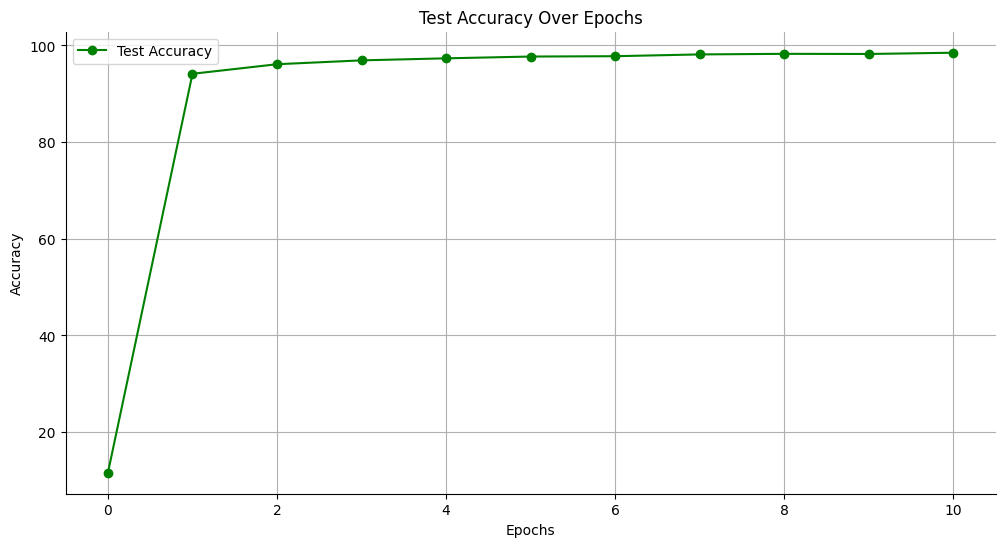

In [17]:
# TASK 2 EXERCISE

# Plot your Results using the function `plot_results`
plot_results(test_accuracies, test_losses, train_losses)

## What is Learned in Convolutional Neural Networks?

The following code contains a function called `preprocess_random_mnist_image` that extracts a random image from an MNIST-style dataset using a `DataLoader`, applies preprocessing transformations, and returns a ready-to-use tensor for model input.

This function is designed to streamline the process of preparing an MNIST image for neural network inference by handling the following tasks:

1. **Data Extraction**: It pulls image data from a `DataLoader` object, which typically wraps around an MNIST dataset.
2. **Random Selection**: It selects a random image from the dataset, simulating a dynamic testing scenario.
3. **Image Conversion**: The selected image is converted from a NumPy array to a PIL image, ensuring compatibility with common image transformation tools.
4. **Preprocessing**: The image undergoes a series of transformations:
   - Converted to a tensor using `transforms.ToTensor()`.
   - Normalized using the standard mean and standard deviation of the MNIST dataset (`mean=0.1307`, `std=0.3081`).
5. **Batch Formatting**: The processed tensor is reshaped to include a batch dimension, resulting in a tensor of shape `[1, 1, H, W]` — the expected input format for most deep learning models.

In [11]:
import numpy as np
from PIL import Image
from torchvision import transforms

def preprocess_random_mnist_image(data_loader, mnist_mean=0.1307, mnist_std=0.3081):
    """
    Extracts a random image from a DataLoader, preprocesses it using MNIST dataset mean and std,
    and returns a batch tensor ready for model input.

    Parameters:
    - data_loader: DataLoader containing the dataset (assumes MNIST format with .data attribute).
    - mnist_mean: Mean value for normalization (default is MNIST mean 0.1307).
    - mnist_std: Standard deviation for normalization (default is MNIST std 0.3081).

    Returns:
    - input_image: A torch tensor of shape [1, 1, H, W], ready for model input.
    """
    # Extract dataset from the DataLoader
    dataset = np.array(data_loader.dataset.data)  # Assuming the DataLoader is for MNIST
    num_images = dataset.shape[0]

    # Randomly select an image
    image_idx = np.random.randint(low=0, high=num_images)
    selected_image = dataset[image_idx]  # Shape: [H, W]

    # Convert to PIL image for consistency
    pil_image = Image.fromarray(selected_image)

    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToTensor(),       # Converts [H, W] to [1, H, W] and scales to [0, 1]
        transforms.Normalize(mean=[mnist_mean], std=[mnist_std])  # Normalize using MNIST stats
    ])

    # Apply preprocessing
    input_tensor = preprocess(pil_image)  # Shape: [1, H, W]

    # Add batch dimension to match model input requirements
    input_image = input_tensor.unsqueeze(0)  # Shape: [1, 1, H, W]

    return input_image

### ANALYZE: Explore What is Learned in CNNs

Tasks:
1. Visualize Convolutional Filters/Weights
  - In this task, you will visualize the filters (weights) learned by the first convolutional layer of a trained CNN model. Filters represent the patterns that the model detects from the input images.
    - Pass your trained model and the name of the first convolutional layer to the function, `visualize_filters_pytorch()`.
2. Visualize Feature Maps
  - Feature maps represent the intermediate outputs generated by the CNN at each layer after applying the filters to an input image.
    - Preprocess a random image from the MNIST dataset using `preprocess_random_mnist_image()`.
    - Call the function `visualize_feature_maps_pytorch()` to visualize the feature maps for a specific layer.
3. Generate Saliency Maps
  - Saliency maps highlight the most important pixels of an input image that influence the model's prediction for a specific class.
    - Saliency maps highlight the most important pixels of an input image that influence the model's prediction for a specific class.
    - Call the function `generate_saliency_map_pytorch()` to generate a saliency map for a given class index.
4. Generate Class Activation Maps (CAMs)
  - Class Activation Maps (CAMs) show which regions of an input image are most relevant to a specific class prediction by the model.
    - Preprocess a random image from the MNIST dataset using `preprocess_random_mnist_image()`.
    - Call the function `generate_cam_pytorch()` to generate a CAM for a given class index and layer.

#### TASK 1: Convolutional Filters/Weights

  - In this task, you will visualize the filters (weights) learned by the first convolutional layer of a trained CNN model. Filters represent the patterns that the model detects from the input images.
    - Pass your trained model and the name of the first convolutional layer to the function, `visualize_filters_pytorch()`.


In [12]:
# --------------------------------------------
# FILTER VISUALIZATION
# --------------------------------------------

def visualize_filters_pytorch(model, layer_name):
    """
    Visualize filters from a specific convolutional layer in a PyTorch model.

    Parameters:
    - model: Trained PyTorch model.
    - layer_name: Name of the convolutional layer to visualize.
    """
    # Extract the layer's weights
    layer = dict(model.named_modules())[layer_name]
    weights = layer.weight.data.cpu().numpy()

    # Normalize the filters to 0-1 for visualization
    filters = (weights - weights.min()) / (weights.max() - weights.min())

    num_filters = filters.shape[0]
    num_columns = 8
    num_rows = int(np.ceil(num_filters / num_columns))

    plt.figure(figsize=(num_columns * 2, num_rows * 2))
    for i in range(num_filters):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(filters[i, 0, :, :], cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"Filters in layer: {layer_name}", fontsize=16)
    plt.show()

In [13]:
# TASK 1 EXERCISE

# Visualize Filters/Weights of your Trained Model
''' ADD YOUR CODE HERE '''

' ADD YOUR CODE HERE '

#### TASK 2: Feature Maps

  - Feature maps represent the intermediate outputs generated by the CNN at each layer after applying the filters to an input image.
    - Preprocess a random image from the MNIST dataset using `preprocess_random_mnist_image()`.
    - Call the function `visualize_feature_maps_pytorch()` to visualize the feature maps for a specific layer.

In [14]:
# --------------------------------------------
# FEATURE MAP VISUALIZATION
# --------------------------------------------

def visualize_feature_maps_pytorch(model, layer_name, input_image):
    """
    Visualize feature maps from a specific layer in a PyTorch model.

    Parameters:
    - model: Trained PyTorch model.
    - layer_name: Name of the layer to visualize.
    - input_image: Input image tensor (should be preprocessed and have shape [1, C, H, W]).
    """

    model.eval()
    hooks = []

    # Hook to capture the output of the specified layer
    def hook_fn(module, input, output):
        hooks.append(output)

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    # Forward pass to get the feature maps
    with torch.no_grad():
        model(input_image)

    # Detach the output and convert to numpy
    feature_maps = hooks[0].detach().cpu().numpy()[0]

    num_maps = feature_maps.shape[0]
    num_columns = 8
    num_rows = int(np.ceil(num_maps / num_columns))

    plt.figure(figsize=(num_columns * 2, num_rows * 2))
    for i in range(num_maps):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(feature_maps[i, :, :], cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"Feature maps in layer: {layer_name}", fontsize=16)
    plt.show()

    # Clean up the hook
    handle.remove()

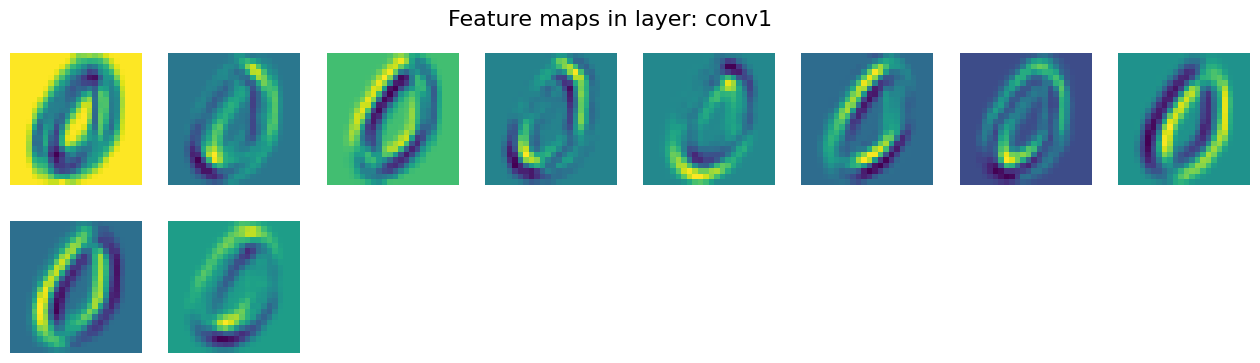

In [18]:
# TASK 2 EXERCISE

# Preprocess an image from the `train_loader` using ``preprocess_random_mnist_image(~)`
input_image = preprocess_random_mnist_image(train_loader)

# Visualize feature maps
visualize_feature_maps_pytorch(conv_network, 'conv1', input_image)

#### TASK 3:  Saliency Maps

  - Saliency maps highlight the most important pixels of an input image that influence the model's prediction for a specific class.
    - Saliency maps highlight the most important pixels of an input image that influence the model's prediction for a specific class.
    - Call the function `generate_saliency_map_pytorch()` to generate a saliency map for a given class index.


In [19]:
# --------------------------------------------
# SALIENCY MAP GENERATION
# --------------------------------------------

def generate_saliency_map_pytorch(model, input_image, class_idx):
    """
    Generate a saliency map for a given input image and class index.

    Parameters:
    - model: Trained PyTorch model.
    - input_image: Input image tensor (requires_grad=True, shape [1, C, H, W]).
    - class_idx: Class index to compute saliency for.
    """
    model.eval()
    input_image.requires_grad_()

    # Forward pass
    output = model(input_image)
    class_score = output[0, class_idx]

    # Backward pass to compute gradients
    class_score.backward()

    # Get the gradients and normalize
    saliency = input_image.grad.data.abs().squeeze().cpu().numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Plot the saliency map
    plt.figure(figsize=(8, 8))
    plt.imshow(saliency, cmap="hot")
    plt.axis("off")
    plt.title("Saliency Map")
    plt.show()

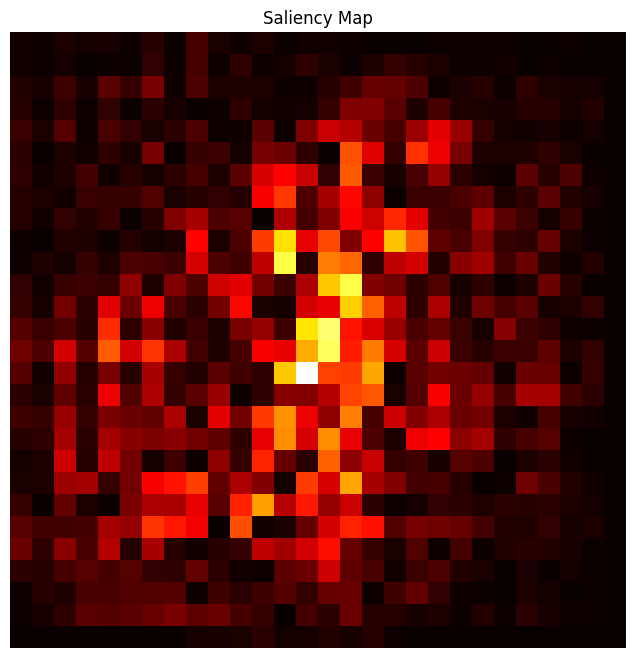

In [20]:
# TASK 3 EXERCISE

# Preprocess an image from the `train_loader` using ``preprocess_random_mnist_image(~)`
input_image = preprocess_random_mnist_image(train_loader)

# Visualize saliency maps
# For demonstration, we'll use class index 0 (the digit '0')
generate_saliency_map_pytorch(conv_network, input_image, class_idx=0)

#### TASK 4: Class Activation Maps (CAM)

  - Class Activation Maps (CAMs) show which regions of an input image are most relevant to a specific class prediction by the model.
    - Preprocess a random image from the MNIST dataset using `preprocess_random_mnist_image()`.
    - Call the function `generate_cam_pytorch()` to generate a CAM for a given class index and layer.


In [22]:
# --------------------------------------------
# CLASS ACTIVATION MAP (CAM) GENERATION
# --------------------------------------------

def generate_cam_pytorch(model, target_layer_name, input_image, class_idx):
    """
    Generate a Class Activation Map (CAM) for a given input image and class index.

    Parameters:
    - model: Trained PyTorch model.
    - target_layer_name: Name of the target convolutional layer.
    - input_image: Input image tensor (should be preprocessed and have shape [1, C, H, W]).
    - class_idx: Class index to compute CAM for.
    """
    model.eval()

    # Store the feature maps and gradients
    feature_maps = []
    gradients = []

    # Hook to capture the feature maps
    def forward_hook(module, input, output):
        feature_maps.append(output)

    # Hook to capture the gradients
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    target_layer = dict(model.named_modules())[target_layer_name]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_image)
    class_score = output[0, class_idx]

    # Backward pass
    model.zero_grad()
    class_score.backward()

    # Get feature maps and gradients
    fmap = feature_maps[0].squeeze(0).detach().cpu().numpy()
    grad = gradients[0].squeeze(0).detach().cpu().numpy()

    # Compute the weighted sum of feature maps
    weights = np.mean(grad, axis=(1, 2))  # Global average pooling on gradients
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * fmap[i]

    # Normalize CAM to 0-1
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Plot the CAM
    plt.figure(figsize=(8, 8))
    plt.imshow(cam, cmap="jet")
    plt.axis("off")
    plt.title(f"Class Activation Map (CAM) for Class {class_idx}")
    plt.show()

    # Clean up hooks
    forward_handle.remove()
    backward_handle.remove()

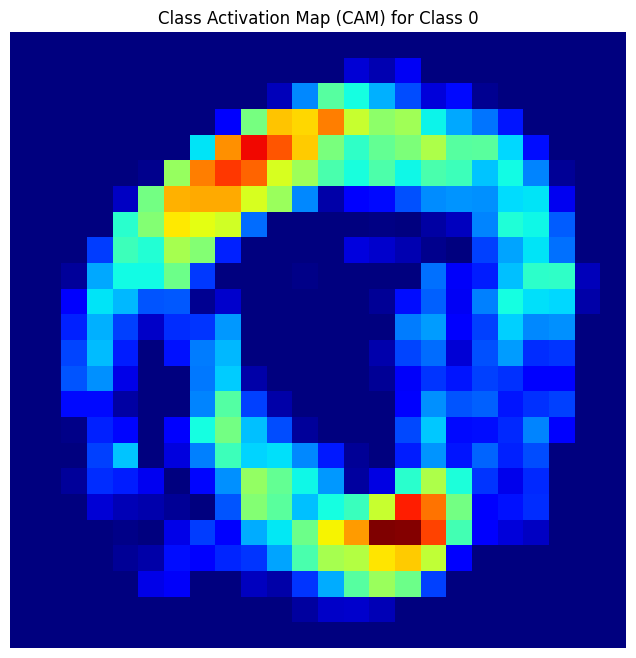

In [23]:
# TASK 4 EXERCISE

# Preprocess an image from the `train_loader` using ``preprocess_random_mnist_image(~)`
input_image = preprocess_random_mnist_image(train_loader)

# Visualize class activation maps
# For demonstration, we'll use 'conv1' as the target layer and class index 0 (the digit '0')
generate_cam_pytorch(conv_network, 'conv1', input_image, class_idx=0)